### At risk

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv(r"C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv")

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance']) * 100 if row['total_required_attendance'] > 0 else 0,
    axis=1
)
df['submitted_date'] = pd.to_datetime(df['submitted_date'])
df['submission_date'] = pd.to_datetime(df['submission_date'])

df['submission_delays'] = df['submitted_date'] - df['submission_date']

df['Conflict_Status'] = (
    (df['academic_attendance_percentage'] < 80) |
    (df['submission_delays'] >= pd.Timedelta(days = 3)) &
    (df['hours_per_week'] > 120)
).astype(int)


print("conflict_status_count:")
print(df['Conflict_Status'].value_counts())

print("\nFirst 5 rows with new percentage column:")
print(df[['student_id', 'classes_attended', 'total_required_attendance', 'academic_attendance_percentage']].head())

conflict_status_count:
Conflict_Status
1    65
0    35
Name: count, dtype: int64

First 5 rows with new percentage column:
  student_id  classes_attended  total_required_attendance  \
0       S001                11                         15   
1       S002                24                         30   
2       S003                12                         24   
3       S004                20                         24   
4       S005                24                         30   

   academic_attendance_percentage  
0                       73.333333  
1                       80.000000  
2                       50.000000  
3                       83.333333  
4                       80.000000  


### Converting assignment grades into numerical values

In [45]:

features = [
    'number_of_courses',
    'classes_attended',
    'assignment_grades',
    'no_of_tasks'
]

encoder = LabelEncoder()

df["assignment_grades"] = encoder.fit_transform(df['assignment_grades'])

x = df[features]
y = df['Conflict_Status']

### Splitting the test and train data

In [46]:

x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.2,random_state=42,stratify=y)


print(f"Training set shape:{x_train.shape}")
print(f"Test set shape:{x_test .shape}")

Training set shape:(80, 4)
Test set shape:(20, 4)


### Training


In [47]:
model = RandomForestClassifier(n_estimators= 100, random_state=42, class_weight="balanced")

model.fit(x_train,y_train)

print("At risk model training complete.")

At risk model training complete.


### Testing

In [48]:
y_pred = model.predict(x_test)

# --- Evaluation ---

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the Confusion Matrix
print("\n--- Confusion Matrix ---")
print("Top-left: True Negatives | Top-right: False Positives")
print("Bottom-left: False Negatives | Bottom-right: True Positives")
print(confusion_matrix(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.73      0.85      0.79        13

    accuracy                           0.70        20
   macro avg       0.67      0.64      0.64        20
weighted avg       0.69      0.70      0.69        20


--- Confusion Matrix ---
Top-left: True Negatives | Top-right: False Positives
Bottom-left: False Negatives | Bottom-right: True Positives
[[ 3  4]
 [ 2 11]]



--- Feature Importances ---
The most important factors the model used for its predictions:
classes_attended     0.403859
no_of_tasks          0.342133
assignment_grades    0.172866
number_of_courses    0.081143
dtype: float64


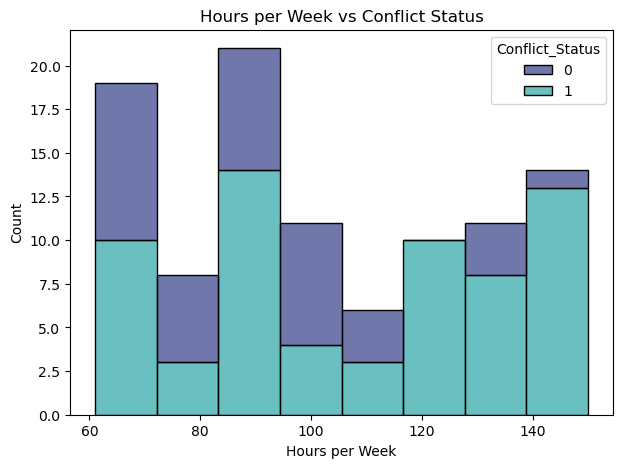

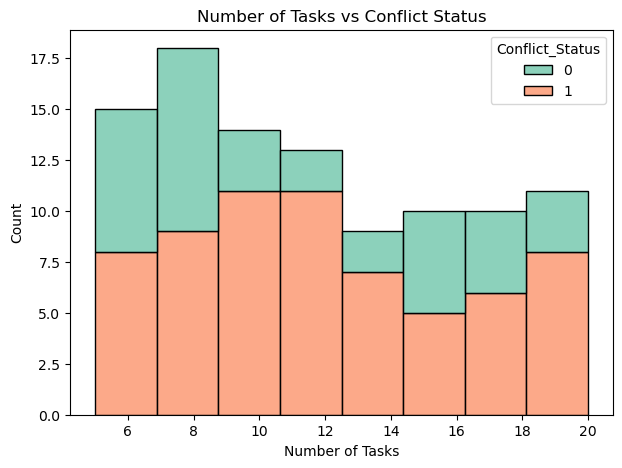

In [49]:
importances = pd.Series(model.feature_importances_, index=x.columns)
importances = importances.sort_values(ascending=False)

print("\n--- Feature Importances ---")
print("The most important factors the model used for its predictions:")
print(importances)

plt.figure(figsize=(7,5))
sns.histplot(data=df, x='hours_per_week', hue='Conflict_Status', multiple='stack', palette='mako')
plt.title("Hours per Week vs Conflict Status")
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(data=df, x='no_of_tasks', hue='Conflict_Status', multiple='stack', palette='Set2')
plt.title("Number of Tasks vs Conflict Status")
plt.xlabel("Number of Tasks")
plt.ylabel("Count")
plt.show()

### Engaement level

Engagement model training complete
---Engagement model classification report---
              precision    recall  f1-score   support

        High       0.25      0.17      0.20         6
         Low       0.50      0.40      0.44         5
      Medium       0.42      0.56      0.48         9

    accuracy                           0.40        20
   macro avg       0.39      0.37      0.37        20
weighted avg       0.39      0.40      0.39        20

---Improtant features---
classes_attended     0.208300
hours_per_week       0.199231
work_study_ratio     0.194300
no_of_tasks          0.160453
assignment_grades    0.096321
submission_delays    0.095315
number_of_courses    0.046080
dtype: float64


C:\Users\sachi\AppData\Local\Temp\ipykernel_25868\2831050057.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Engagement', data=df, palette='viridis', order=['High','Medium','Low'])


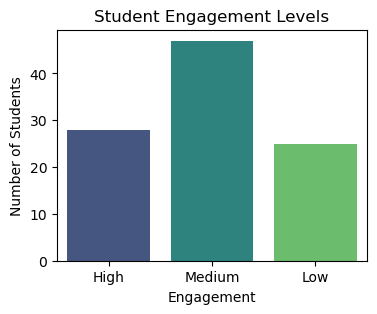

In [50]:
#Engagement Levels

df['work_study_ratio'] = df.apply(
    lambda row: (row['hours_per_week'] / row['number_of_courses']),
    axis=1
)
conditions = [
 (df['academic_meeting_date'].notna()) & (df['industry_meeting_date'].notna()),
    (df['academic_meeting_date'].notna()) | (df['industry_meeting_date'].notna())
]

outcomes = ['High','Medium']

df["Engagement"] = np.select(conditions, outcomes, default="Low")

features = [
    'number_of_courses',
    'classes_attended',
    'submission_delays',
    'assignment_grades',
    'hours_per_week',
    'no_of_tasks',
    'work_study_ratio'
]

encoder = LabelEncoder()

df["assignment_grades"] = encoder.fit_transform(df['assignment_grades'])

x= df[features]
y= df["Engagement"]

x_train , x_test , y_train , y_test = train_test_split(
   x,y, test_size=0.2 , random_state=42 , stratify=y
)

x_train['submission_delays'] = x_train['submission_delays'].dt.days
x_test['submission_delays'] = x_test['submission_delays'].dt.days


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train,y_train)
print("Engagement model training complete")

y_pred = model.predict(x_test)
print("---Engagement model classification report---")
print(classification_report(y_test,y_pred))


importances = pd.Series(model.feature_importances_, index=x.columns)
importances = importances.sort_values(ascending=False)
print("---Improtant features---")
print(importances)

plt.figure(figsize=(4,3))
sns.countplot(x='Engagement', data=df, palette='viridis', order=['High','Medium','Low'])
plt.title('Student Engagement Levels')
plt.xlabel('Engagement')
plt.ylabel('Number of Students')
plt.show()

### pass or fail

pass_fail counts:
pass_fail
0    80
1    20
Name: count, dtype: int64
trainig set size'(80, 5)
test set size'(20, 5)
model training complete
classification_report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.25      0.40         4

    accuracy                           0.85        20
   macro avg       0.92      0.62      0.66        20
weighted avg       0.87      0.85      0.81        20

confusion_matrix:
TN | FP
FN | TP
[[16  0]
 [ 3  1]]


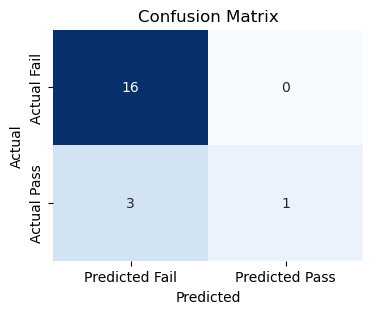

importance: 
hours_per_week             0.329105
classes_attended           0.264072
no_of_tasks                0.213271
num_mitigation_requests    0.122862
number_of_courses          0.070689
dtype: float64


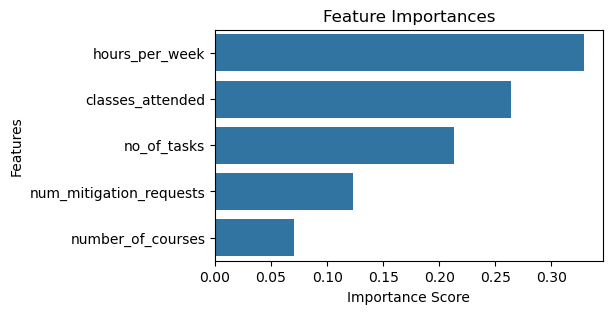

C:\Users\sachi\AppData\Local\Temp\ipykernel_25868\3102521150.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pass_fail', data=df, palette='coolwarm')


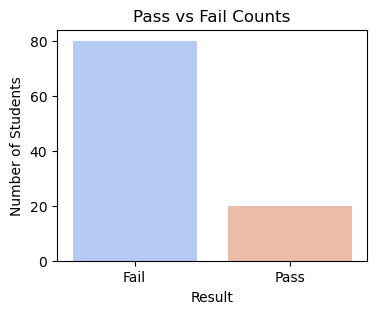

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv')

#attendance percentage

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance']) * 100 , axis = 1
)


grade_map = {'A1': 5, 'A2': 4, 'B1': 3, 'B2': 2, 'C1': 1, 'C2': 1, 'Fail': 0}
df['assignment_grades'] = df['assignment_grades'].map(grade_map)


df['pass_fail'] = ((
    df['academic_attendance_percentage'] > 80) & (df['assignment_grades'] > 1)).astype(int)

print('pass_fail counts:')
print(df['pass_fail'].value_counts())

features = [
    'number_of_courses',
    'classes_attended',
    'hours_per_week',
    'no_of_tasks',
    'num_mitigation_requests',
    
]

x = df[features]
y = df['pass_fail']

x_train , x_test , y_train , y_test = train_test_split(
    x,y,test_size=0.2 ,random_state= 42,stratify=y
)

print(f"trainig set size'{x_train.shape}")
print(f"test set size'{x_test.shape}")

model = RandomForestClassifier(n_estimators=100 , random_state= 42 , class_weight= "balanced")
model.fit(x_train,y_train)

print("model training complete")

y_pred = model.predict(x_test)

print("classification_report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print("confusion_matrix:")
print("TN | FP\nFN | TP")
print(cm)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=['Predicted Fail','Predicted Pass'],
            yticklabels=['Actual Fail','Actual Pass'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


importances = pd.Series(model.feature_importances_,index = features)
importances = importances.sort_values(ascending=False)
print("importance: ")
print(importances)

plt.figure(figsize=(5,3))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

plt.figure(figsize=(4,3))
sns.countplot(x='pass_fail', data=df, palette='coolwarm')
plt.xticks([0, 1], ['Fail', 'Pass'])
plt.title('Pass vs Fail Counts')
plt.xlabel('Result')
plt.ylabel('Number of Students')
plt.show()


### Grade prediction

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv')

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance'] * 100) , axis=1
)

grade_map = {'A1': 5, 'A2': 4, 'B1': 3, 'B2': 2, 'C1': 1, 'C2': 1, 'Fail': 0}
df['assignment_grades'] = df['assignment_grades'].map(grade_map)
df['assignment_score'] = (df['assignment_grades']/5)*100


df['activity_score'] = ((df['hours_per_week']/df['hours_per_week'].max())*50 + 
                        (df['no_of_tasks']/df['no_of_tasks'].max())*50 -
                        df['num_mitigation_requests']/df['num_mitigation_requests'].max()+1)

df['activity_score'] = df['activity_score'].clip(0, 100)


df['final_score'] = df['academic_attendance_percentage']*0.4 + df['assignment_score']*0.4 + df['activity_score']*0.2

df['attendance_ratio'] = (df['classes_attended']/df['total_required_attendance'])
df['mitigation_impact'] = (df['num_mitigation_requests']/(df['num_mitigation_requests'].max()+1))

features = [
    'number_of_courses',
    'classes_attended',
    'assignment_score',
    'attendance_ratio',
    'mitigation_impact',
]

x = df[features]
y = df['final_score']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(
    x_scaled,y,test_size=0.2,random_state=42
)

model = LinearRegression()
model.fit(x_train, y_train)
print("Leniar regression model trained")

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

def score_to_grade(score):
    if score >= 85: return 'A'
    elif score >= 70: return 'B'
    elif score >= 50: return 'C'
    else: return 'D'
y_pred_full = model.predict(x_scaled)
df['predicted_grade'] = y_pred_full
df['predicted_letter'] = df['predicted_grade'].apply(score_to_grade)

print(df['predicted_letter'])


Leniar regression model trained
Mean Squared Error (MSE): 14.77
Mean Absolute Error (MAE): 3.51
R^2 Score: 0.94
0     C
1     D
2     D
3     C
4     C
     ..
95    D
96    C
97    D
98    C
99    A
Name: predicted_letter, Length: 100, dtype: object


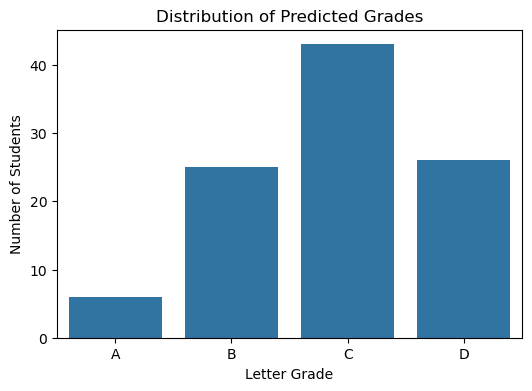

In [53]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='predicted_letter', order=['A','B','C','D'])
plt.title("Distribution of Predicted Grades")
plt.xlabel("Letter Grade")
plt.ylabel("Number of Students")
plt.show()




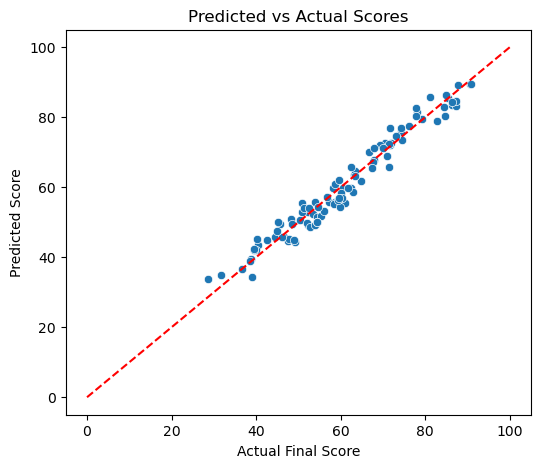

In [54]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=df['final_score'], y=df['predicted_grade'])
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Scores")
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # ideal line
plt.show()